**1: Imports and Data Loading**

In [9]:
import os
import sys
import yaml
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import random
import scipy

In [10]:
# Add the project root to the Python path
# This allows us to import our custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.components.data_ingestion import DataIngestion
from src.exception import CustomException

# Get the structured data paths
try:
    ingestion = DataIngestion()
    data_paths = ingestion.get_data_paths()
    print(f"Found {len(data_paths)} data points.")
except Exception as e:
    raise CustomException(e, sys)

Found 51288 data points.


**2: Visualization Helper Function**

In [11]:
def draw_3d_bounding_box(image, pose, intrinsics, object_model_path, color=(0, 255, 0)):
    """Draws a 3D bounding box on a 2D image."""
    
    # 1. Load the 3D model and get its bounding box
    mesh = o3d.io.read_triangle_mesh(object_model_path)
    bbox_3d = mesh.get_axis_aligned_bounding_box()
    corners_3d = np.asarray(bbox_3d.get_box_points()) # 8 corners in 3D

    # 2. Project 3D corners to 2D image plane
    # Add a column of 1s for homogeneous coordinates
    corners_3d_hom = np.hstack((corners_3d, np.ones((8, 1))))
    
    # Transform points using the object's pose
    transformed_corners = (pose @ corners_3d_hom.T).T
    
    # Project points using the camera intrinsic matrix
    projected_points = (intrinsics @ transformed_corners[:, :3].T).T
    
    # Normalize by the z-coordinate
    projected_points_2d = projected_points[:, :2] / projected_points[:, 2:]
    projected_points_2d = projected_points_2d.astype(int)

    # 3. Draw the edges of the bounding box
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]

    for edge in edges:
        start_point = tuple(projected_points_2d[edge[0]])
        end_point = tuple(projected_points_2d[edge[1]])
        cv2.line(image, start_point, end_point, color, 2)
        
    return image

**3: Main Visualization**

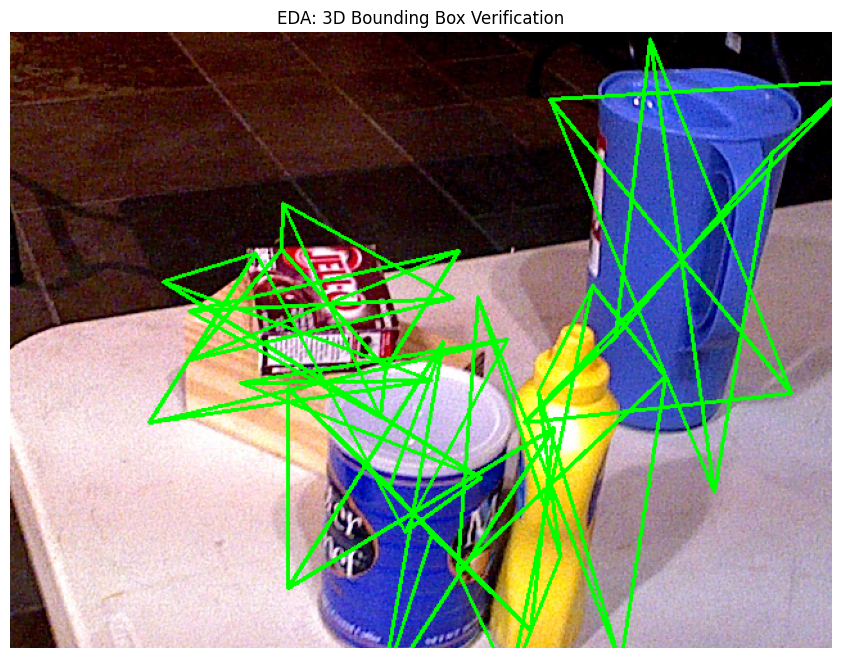

In [14]:
# Select a random sample from our data
sample = random.choice(data_paths)

# Load the RGB image
image = cv2.imread(sample['rgb_path'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert for matplotlib

# Get camera intrinsics
intrinsics = np.array(sample['camera_intrinsics'])

# Map class IDs to model names (you may need to create a mapping file for this)
# For now, we'll manually list them. A file like 'models/class_map.yml' is a good practice.
class_id_to_name = {
    1: "002_master_chef_can", 2: "003_cracker_box", 3: "004_sugar_box", 
    4: "005_tomato_soup_can", 5: "006_mustard_bottle", 6: "007_tuna_fish_can", 
    7: "008_pudding_box", 8: "009_gelatin_box", 9: "010_potted_meat_can", 
    10: "011_banana", 11: "019_pitcher_base", 12: "021_bleach_cleanser", 
    13: "024_bowl", 14: "025_mug", 15: "035_power_drill", 16: "036_wood_block", 
    17: "037_scissors", 18: "040_large_marker", 19: "051_large_clamp", 
    20: "052_extra_large_clamp", 21: "061_foam_brick"
}

# Loop through each object in the frame and draw its bounding box
for obj in sample['objects']:
    class_id = obj['class_id']
    pose = np.array(obj['pose'])
    model_name = class_id_to_name.get(class_id)
    
    if model_name:
        model_path = os.path.join('..', 'datasets', 'models', model_name, 'textured.obj')
        if os.path.exists(model_path):
            image = draw_3d_bounding_box(image, pose, intrinsics, model_path)
        else:
            print(f"Model path not found: {model_path}")

# Display the final image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.title("EDA: 3D Bounding Box Verification")
plt.show()